In [1]:
from func import *

import pickle as p
import glob 
import json
import subprocess
import getpass
import os

In [2]:
# ",".join(os.listdir('/home/abhijit/Jyotirmay/abdominal_segmentation/quickNAT_pytorch/create_datasets/datasets/lablmaps/UKB'))

In [3]:
volume_txt_file = 'datasets/ukb/volumes.txt'
data_dir = "/home/abhijit/nas_drive/Data_WholeBody/UKBiobank/body/body_nifti"
label_dir = 'datasets/lablmaps/UKB'

n4_corrected_data_dir = "temp/UKB/n4_corrected"
stictched_data_dir = "temp/UKB//stitched"
stitched_n4_corrected_data_dir = "temp/UKB/stitched_n4_corrected"

processed_path = 'temp/UKB/'
processed_dir = 'temp/UKB/processed'

one_time_n4_optimization = True

In [4]:
def load_ukb_file_paths(load_from_txt_file=True):
    volumes_to_use = []
    if load_from_txt_file:
        with open(volume_txt_file) as file_handle:
                volumes_to_use = file_handle.read().splitlines()
    else:
        volumes_to_use = [name for name in os.listdir(data_dir)]
    
    file_paths = {}
    
    for vol in volumes_to_use:
        if vol == "":
            continue
        opp_paths = glob.glob(f'{data_dir}/{vol}/**opp**.nii.gz')
        in_paths = glob.glob(f'{data_dir}/{vol}/**in**.nii.gz')
        f_paths = glob.glob(f'{data_dir}/{vol}/**F**.nii.gz')
        w_paths = glob.glob(f'{data_dir}/{vol}/**W**.nii.gz')
        
        labelmap_paths = glob.glob(f'{label_dir}/{vol}/**')
        
        vol_madals_paths = dict(
        OPP=opp_paths,
        IN=in_paths,
        F=f_paths,
        W=w_paths
        )
        file_paths[str(vol)]=dict(
            VOLUME_PATHS=vol_madals_paths,
            LABEL_PATHS=labelmap_paths,
        )
    return file_paths
        

In [ ]:
file_paths = load_ukb_file_paths()

In [ ]:
 print(json.dumps(file_paths,sort_keys=True, indent=4))

In [ ]:
# Individual RESCALING.
n4_dict = {}
for vol in file_paths.keys():
    if one_time_n4_optimization:
        break
    print(f'n4 processing part-1 started with {vol}...')
    n4_dict[vol] = []
    vol_parts = [[file, read_ras(file)] for file in file_paths[vol]['VOLUME_PATHS']['IN']]
    for orig_file, in_image in vol_parts:
        n4_dict[vol].append(rescale(in_image, vol, orig_file))

In [ ]:
# TODO: EXECUTE 'sudo sh ./n4-anne.sh' from command line for n4 bais field generation of all in imgs.

for vol in file_paths.keys():
    if one_time_n4_optimization:
        break
    print(f'applying n4 bias field on opp scans of {vol}...')
    vol_parts = [[read_ras(opp_file), read_ras(n4_counterpart['IN_BIAS']), opp_file] for opp_file, n4_counterpart in zip(file_paths[vol]['VOLUME_PATHS']['OPP'],n4_dict[vol])]
    idx = 0
    file_paths[vol]['N4_1'] = []
    for opp_img, bias_field_img, opp_file in vol_parts:
        file_paths[vol]['N4_1'].append(apply_bias_field(opp_img, bias_field_img, opp_file, n4_dict[vol][idx], vol))
        idx+=1
#         n4_dict[vol].append(rescale(opp_image, vol, n4_dict[vol]))



In [ ]:
# STITCHING VOL PARTS HERE
for vol in file_paths.keys():
    print(f'started with {vol}...')
    create_if_not(f'{n4_corrected_data_dir}/vol/{vol}')
    file_paths[vol]['ONE'] = {}
    for modality_key in file_paths[vol]['VOLUME_PATHS'].keys():
        print(f"processing {modality_key}")
        orig_modal_key = modality_key
        if one_time_n4_optimization:
            vol_parts = [read_ras(file) for file in file_paths[vol]['VOLUME_PATHS'][modality_key]]
        else:
            if modality_key == 'OPP':
                vol_parts = [read_ras(data_dict['OPP_CORRECTED']) for data_dict in file_paths[vol]['N4_1']]
                modality_key = modality_key+'_n4_corrected'
            else:
                vol_parts = [read_ras(file) for file in file_paths[vol]['VOLUME_PATHS'][modality_key]]

        ras_stitched = multi_vol_stitching(vol_parts)
        save_volume(ras_stitched, f'{n4_corrected_data_dir}/vol/{vol}/{modality_key}_ras_stitched')
        file_paths[vol]['ONE'][f'{orig_modal_key}'] = f'{n4_corrected_data_dir}/vol/{vol}/{modality_key}_ras_stitched.nii.gz'

In [ ]:
# RESCALING INTENSITIES OF STITCHED VOLUME ABOVE 0
n4_dict = {}
for vol in file_paths.keys():
    print(f'n4 processing part-2 started with {vol}...')
    n4_dict[vol] = {}
    in_stitched_file_path, in_stitched_img = file_paths[vol]['ONE']['IN'], read_ras(file_paths[vol]['ONE']['IN'])
    n4_dict[vol]['N4_2'] = rescale(in_stitched_img, vol, in_stitched_file_path)

In [ ]:
# TODO: EXECUTE 'sudo sh ./n4-anne-2.sh' from command line for n4 bais field generation of all in imgs.
for vol in file_paths.keys():
    print(f'applying n4 bias field on stitched opp scans of {vol}...')

    opp_file = file_paths[vol]['ONE']['OPP']
    n4_counterpart = n4_dict[vol]['N4_2']
    print(opp_file, n4_counterpart['IN_BIAS'])
    opp_img = read_ras(opp_file)
    bias_field_img = read_ras(n4_counterpart['IN_BIAS'])

    file_paths[vol]['N4_2'] = apply_bias_field(opp_img, bias_field_img, opp_file, n4_dict[vol]['N4_2'], vol)

In [ ]:
with open('nako_file_paths.p', 'wb') as handle:
    p.dump(file_paths, handle, protocol=p.HIGHEST_PROTOCOL)

In [5]:
with open('nako_file_paths.p', 'rb') as handle:
    file_paths = p.load(handle)

In [6]:
def vol_label_fix(vol, label):
    vol_vol = np.product(vol.shape)
    label_vol = np.product(label.shape)
    
    world_shape = np.max(np.array([list(vol.shape), list(label.shape)]), axis=0)
    print(tuple(world_shape))
    final_label = np.zeros(tuple(world_shape))
    label_affine = label.affine
    vol_affine = vol.affine
    if(vol_vol>label_vol):
#         final_label = np.zeros(vol.shape)
        target_affine = vol_affine
        target_header = vol.header
        target_dim_v = vol.shape
        
#         labelmap2vol = npl.inv(target_affine).dot(label_affine)
#         start_inv = np.floor(apply_affine(labelmap2vol, [0,0,0])).astype(np.int32)
#         sx, sy,sz = start_inv
#         end_inv = apply_affine(labelmap2vol, target_dim_v).astype(np.int32)
#         final_label = np.zeros(end_inv)
#         ex, ey, ez = end_inv
#         print("seg start inv v: ",start_inv , "segm end inv v:",end_inv)
        sx,sy,sz,ex,ey,ez = np.abs(get_points(label, vol))
        print(sx,sy,sz,ex,ey,ez)
        final_label[0:ex+sx, 0:ey+sy, sz:ez] = label.get_fdata()
        final_label = np.flip(final_label, axis=0)
        final_label = np.flip(final_label, axis=1)
        final_label_img = nb.Nifti1Image(final_label, target_affine, target_header)
        volume, label = vol, final_label_img
    else:
#         final_label = np.zeros(label.shape)
        target_affine = label_affine
        target_header = label.header
        target_dim_v = label.shape
        
#         labelmap2vol = npl.inv(target_affine).dot(vol_affine)
#         start_inv = np.floor(apply_affine(labelmap2vol, [0,0,0])).astype(np.int32)
#         sx, sy,sz = start_inv
#         end_inv = apply_affine(labelmap2vol, target_dim_v).astype(np.int32)
#         final_label = np.zeros(end_inv)
#         ex, ey, ez = end_inv
#         print("seg start inv v: ",start_inv , "segm end inv v:",end_inv)
        sx,sy,sz,ex,ey,ez = np.abs(get_points(vol, label))
        print(sx,sy,sz,ex,ey,ez)
        final_label = np.flip(final_label, axis=0)
        final_label = np.flip(final_label, axis=1)
        final_label[0:ex+sx, 0:ey+sy, sz:ez] = vol.get_fdata()
        
        final_label_img = nb.Nifti1Image(final_label, target_affine, target_header)
        volume, label = final_label_img, label
    
    return volume, label

STARTING NAKO LABEL-MAPS.
Reading Label Maps.....
1138634_20201_2_0
3387088_20201_2_0
1942395_20201_2_0
1019631_20201_2_0
5764643_20201_2_0
1013250_20201_2_0
1584559_20201_2_0
1013391_20201_2_0
1108214_20201_2_0
5397022_20201_2_0
5934622_20201_2_0
4154467_20201_2_0
1026125_20201_2_0
1005379_20201_2_0
5371767_20201_2_0
4627690_20201_2_0
1883132_20201_2_0
['datasets/lablmaps/UKB/1883132_20201_2_0/1883132_Dixon_BH_17s_opp_Dixon_BH_17s.nrrd_Adrenal gland (right).nrrd', 'datasets/lablmaps/UKB/1883132_20201_2_0/1883132_Dixon_BH_17s_opp_Dixon_BH_17s.nrrd_subcutan fat.nrrd', 'datasets/lablmaps/UKB/1883132_20201_2_0/1883132_Dixon_BH_17s_opp_Dixon_BH_17s_Kidney(right).nrrd', 'datasets/lablmaps/UKB/1883132_20201_2_0/1883132_Dixon_BH_17s_opp_Dixon_BH_17s.nrrd_Pancreas.nrrd', 'datasets/lablmaps/UKB/1883132_20201_2_0/1883132_Dixon_BH_17s_opp_Dixon_BH_17s.nrrd_Gallblader.nrrd', 'datasets/lablmaps/UKB/1883132_20201_2_0/1883132_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-4_Adrenal gland (left).nrrd', 'dataset

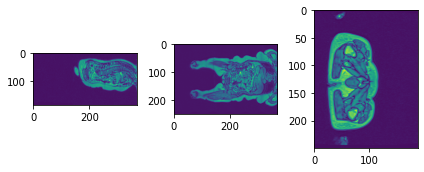

Affine:[[ 2.00000000e+00  0.00000000e+00  0.00000000e+00 -2.47767883e+02]
 [ 0.00000000e+00  2.00000000e+00  0.00000000e+00 -1.85267883e+02]
 [ 0.00000000e+00  0.00000000e+00  3.00000000e+00 -1.04100000e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]], Image Shape: (250, 195, 370)


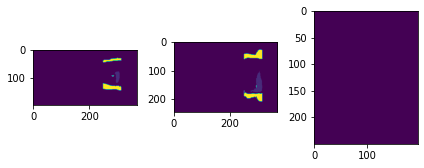

Saving Processed & Stitched Image.....
saving directory: temp/UKB/processed/volume
saving directory: temp/UKB/processed/label
FINISHED.
1004985_20201_2_0
['datasets/lablmaps/UKB/1004985_20201_2_0/1004985_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-4_Pancreas.nrrd', 'datasets/lablmaps/UKB/1004985_20201_2_0/1004985_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-4_Kidney(right).nrrd', 'datasets/lablmaps/UKB/1004985_20201_2_0/ 1004985_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-4_Adrenal gland(left).nrrd', 'datasets/lablmaps/UKB/1004985_20201_2_0/1004985_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-4_Spleen.nrrd', 'datasets/lablmaps/UKB/1004985_20201_2_0/1004985_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-4_Liver.nrrd', 'datasets/lablmaps/UKB/1004985_20201_2_0/1004985_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-4_Adrenal gland (right).nrrd', 'datasets/lablmaps/UKB/1004985_20201_2_0/1004985_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-4_Gallbladder.nrrd', 'datasets/lablmaps/UKB/1004985_20201_2_0/1004985_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-4_K

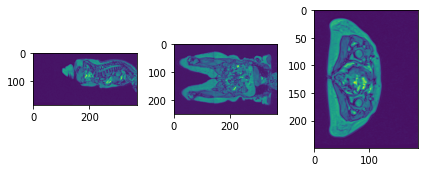

Affine:[[ 2.00000000e+00  0.00000000e+00  0.00000000e+00 -2.47767883e+02]
 [ 0.00000000e+00  2.00000000e+00  0.00000000e+00 -1.85267883e+02]
 [ 0.00000000e+00  0.00000000e+00  3.00000000e+00 -1.04100000e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]], Image Shape: (250, 195, 370)


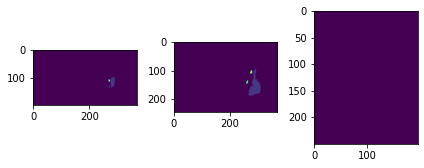

Saving Processed & Stitched Image.....
saving directory: temp/UKB/processed/volume
saving directory: temp/UKB/processed/label
FINISHED.
1036900_20201_2_0
['datasets/lablmaps/UKB/1036900_20201_2_0/1036900_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-21_Pancreas.nrrd', 'datasets/lablmaps/UKB/1036900_20201_2_0/1036900_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-21_Spleen.nrrd', 'datasets/lablmaps/UKB/1036900_20201_2_0/1036900_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-21_Gallbladder.nrrd', 'datasets/lablmaps/UKB/1036900_20201_2_0/1036900_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-21_Kidney(left).nrrd', 'datasets/lablmaps/UKB/1036900_20201_2_0/1036900_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-21_Liver.nrrd', 'datasets/lablmaps/UKB/1036900_20201_2_0/1036900_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-21_Adrenal gland(left).nrrd', 'datasets/lablmaps/UKB/1036900_20201_2_0/1036900_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-21_Kidney(right).nrrd', 'datasets/lablmaps/UKB/1036900_20201_2_0/1036900_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-21_Adr

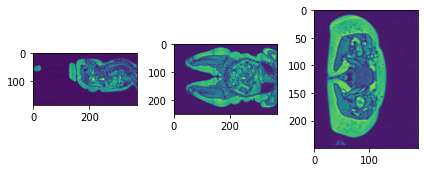

Affine:[[ 2.00000000e+00  0.00000000e+00  0.00000000e+00 -2.47767883e+02]
 [ 0.00000000e+00  2.00000000e+00  0.00000000e+00 -1.85267883e+02]
 [ 0.00000000e+00  0.00000000e+00  3.00000000e+00 -1.04100000e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]], Image Shape: (250, 195, 370)


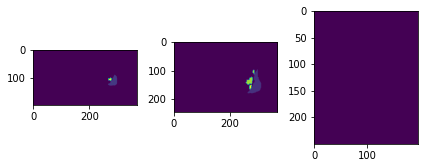

Saving Processed & Stitched Image.....
saving directory: temp/UKB/processed/volume
saving directory: temp/UKB/processed/label
FINISHED.
5833278_20201_2_0
['datasets/lablmaps/UKB/5833278_20201_2_0/5833278_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Kidney(left).nrrd', 'datasets/lablmaps/UKB/5833278_20201_2_0/5833278_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Gallbladder.nrrd', 'datasets/lablmaps/UKB/5833278_20201_2_0/5833278_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Pancreas.nrrd', 'datasets/lablmaps/UKB/5833278_20201_2_0/5833278_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Spleen.nrrd', 'datasets/lablmaps/UKB/5833278_20201_2_0/5833278_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Kidney(right).nrrd', 'datasets/lablmaps/UKB/5833278_20201_2_0/5833278_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Adrenal gland(right).nrrd', 'datasets/lablmaps/UKB/5833278_20201_2_0/5833278_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Adrenal gland(left).nrrd', 'datasets/lablmaps/UKB/5833278_20201_2_0/5833278_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Liver.nrrd']

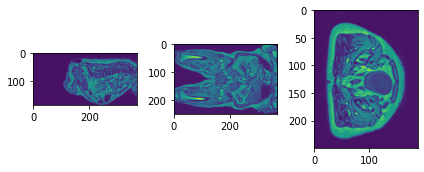

Affine:[[ 2.00000000e+00  0.00000000e+00  0.00000000e+00 -2.47767883e+02]
 [ 0.00000000e+00  2.00000000e+00  0.00000000e+00 -1.85267883e+02]
 [ 0.00000000e+00  0.00000000e+00  3.00000000e+00 -1.04100000e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]], Image Shape: (250, 195, 370)


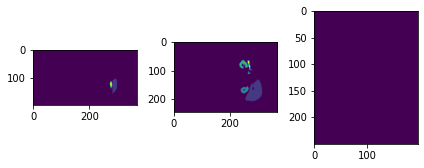

Saving Processed & Stitched Image.....
saving directory: temp/UKB/processed/volume
saving directory: temp/UKB/processed/label
FINISHED.
1003082_20201_2_0
['datasets/lablmaps/UKB/1003082_20201_2_0/1003082_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-4_Liver.nrrd', 'datasets/lablmaps/UKB/1003082_20201_2_0/1003082_Dixon_BH_17s_opp_Dixon_BH_17sa-3_Kidney (left)-3.nrrd', 'datasets/lablmaps/UKB/1003082_20201_2_0/1003082_Dixon_BH_17s_W_Dixon_BH_17sa.nii_Gallbladder.nrrd', 'datasets/lablmaps/UKB/1003082_20201_2_0/1003082_Dixon_BH_17s_F_Dixon_BH_17sa.nrrd_Adrenal gland (left).nrrd', 'datasets/lablmaps/UKB/1003082_20201_2_0/1003082_Dixon_BH_17s_F_Dixon_BH_17sa.nrrd_Adrenal gland (right).nrrd', 'datasets/lablmaps/UKB/1003082_20201_2_0/1003082_opp_17sa_spleen.nrrd', 'datasets/lablmaps/UKB/1003082_20201_2_0/1003082_Dixon_BH_17s_opp_Dixon_BH_17sa-3_Kidney(right).nrrd', 'datasets/lablmaps/UKB/1003082_20201_2_0/1003082_Dixon_BH_17s_opp_Dixon_BH_17sa.nrrd_Pancreas.nrrd', 'datasets/lablmaps/UKB/1003082_20201_2_

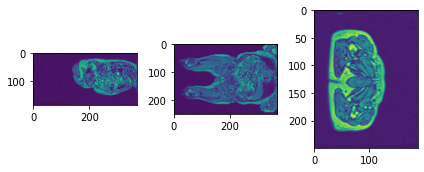

Affine:[[ 2.00000000e+00  0.00000000e+00  0.00000000e+00 -2.47767883e+02]
 [ 0.00000000e+00  2.00000000e+00  0.00000000e+00 -1.85267883e+02]
 [ 0.00000000e+00  0.00000000e+00  3.00000000e+00 -1.04100000e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]], Image Shape: (250, 195, 370)


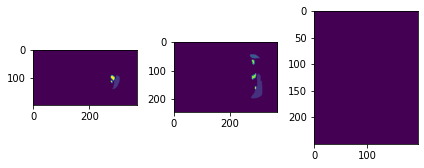

Saving Processed & Stitched Image.....
saving directory: temp/UKB/processed/volume
saving directory: temp/UKB/processed/label
FINISHED.
6025746_20201_2_0
['datasets/lablmaps/UKB/6025746_20201_2_0/6025746_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Kidney(right).nrrd', 'datasets/lablmaps/UKB/6025746_20201_2_0/6025746_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Adrenal gland(left).nrrd', 'datasets/lablmaps/UKB/6025746_20201_2_0/6025746_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Adrenal gland(right).nrrd', 'datasets/lablmaps/UKB/6025746_20201_2_0/6025746_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Pancreas.nrrd', 'datasets/lablmaps/UKB/6025746_20201_2_0/6025746_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Liver.nrrd', 'datasets/lablmaps/UKB/6025746_20201_2_0/6025746_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Spleen.nrrd', 'datasets/lablmaps/UKB/6025746_20201_2_0/6025746_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Kidney(left).nrrd']
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
Reading Files.....
Reading NR

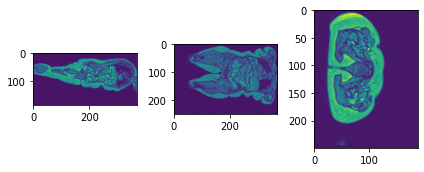

Affine:[[ 2.00000000e+00  0.00000000e+00  0.00000000e+00 -2.47767883e+02]
 [ 0.00000000e+00  2.00000000e+00  0.00000000e+00 -1.85267883e+02]
 [ 0.00000000e+00  0.00000000e+00  3.00000000e+00 -1.04100000e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]], Image Shape: (250, 195, 370)


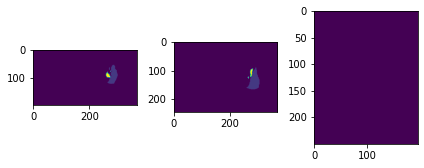

Saving Processed & Stitched Image.....
saving directory: temp/UKB/processed/volume
saving directory: temp/UKB/processed/label
FINISHED.
5331775_20201_2_0
['datasets/lablmaps/UKB/5331775_20201_2_0/5331775_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Liver.nrrd', 'datasets/lablmaps/UKB/5331775_20201_2_0/5331775_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Kidney(right).nrrd', 'datasets/lablmaps/UKB/5331775_20201_2_0/5331775_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Pancreas.nrrd', 'datasets/lablmaps/UKB/5331775_20201_2_0/5331775_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Adrenal gland(left).nrrd', 'datasets/lablmaps/UKB/5331775_20201_2_0/5331775_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Adrenal gland(right).nrrd', 'datasets/lablmaps/UKB/5331775_20201_2_0/5331775_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Kidney(left).nrrd', 'datasets/lablmaps/UKB/5331775_20201_2_0/5331775_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Gallbladder.nrrd', 'datasets/lablmaps/UKB/5331775_20201_2_0/5331775_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Spleen.nrrd']

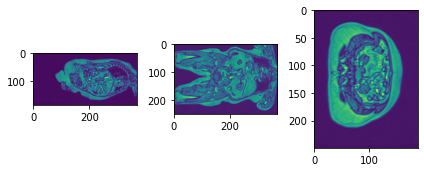

Affine:[[ 2.00000000e+00  0.00000000e+00  0.00000000e+00 -2.47767883e+02]
 [ 0.00000000e+00  2.00000000e+00  0.00000000e+00 -1.85267883e+02]
 [ 0.00000000e+00  0.00000000e+00  3.00000000e+00 -1.04100000e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]], Image Shape: (250, 195, 370)


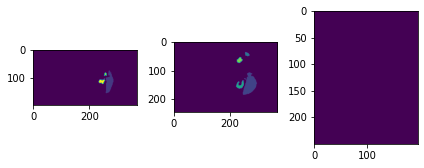

Saving Processed & Stitched Image.....
saving directory: temp/UKB/processed/volume
saving directory: temp/UKB/processed/label
FINISHED.
1004466_20201_2_0
[]
#################### ALERT:: NO LABELPATHS IN THE DICTIONARY FOR 1004466_20201_2_0 #########################
1002359_20201_2_0
['datasets/lablmaps/UKB/1002359_20201_2_0/1002359_opp_17sb_Spleen.nii_.nrrd', 'datasets/lablmaps/UKB/1002359_20201_2_0/1002359_Dixon_BH_17s_opp_Dixon_BH_17sb.nrrd_Adrenal gland(right).nrrd', 'datasets/lablmaps/UKB/1002359_20201_2_0/1002359_Dixon_opp_BH_17sb_combi_Kidney (right).nrrd', 'datasets/lablmaps/UKB/1002359_20201_2_0/1002359_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-4_KIdney(left).nrrd', 'datasets/lablmaps/UKB/1002359_20201_2_0/1002359Dixon_opp_BH_17sb.niiLiver (2)-2.nrrd', 'datasets/lablmaps/UKB/1002359_20201_2_0/1002359_Dixon_BH_17s_opp_Dixon_BH_17sb.nrrd_Pancreas.nrrd', 'datasets/lablmaps/UKB/1002359_20201_2_0/1002359_Dixon_BH_17s_opp_Dixon_BH_17sb.nrrd_Adrenal gland(left).nrrd', 'datasets/lablmaps/UK

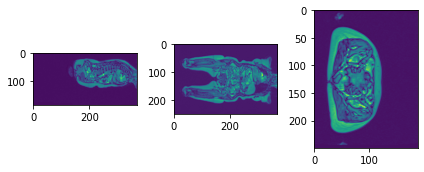

Affine:[[ 2.00000000e+00  0.00000000e+00  0.00000000e+00 -2.47767883e+02]
 [ 0.00000000e+00  2.00000000e+00  0.00000000e+00 -1.85267883e+02]
 [ 0.00000000e+00  0.00000000e+00  3.00000000e+00 -1.04100000e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]], Image Shape: (250, 195, 370)


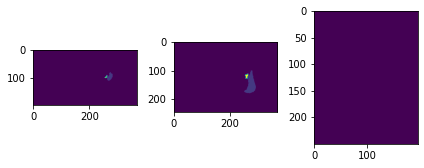

Saving Processed & Stitched Image.....
saving directory: temp/UKB/processed/volume
saving directory: temp/UKB/processed/label
FINISHED.


In [7]:
print("STARTING NAKO LABEL-MAPS.")
print('Reading Label Maps.....')
processed = True
for vol in file_paths.keys():
    print(vol)
    if vol == '1883132_20201_2_0':
        processed = False
    if processed:
        continue
    later = None
    print(file_paths[vol]['LABEL_PATHS'])
    if len(file_paths[vol]['LABEL_PATHS']) == 0:
        print(f"#################### ALERT:: NO LABELPATHS IN THE DICTIONARY FOR {vol} #########################")
        continue
        
    volume = nb.load(file_paths[vol]['N4_2']['OPP_CORRECTED'])
    img_ras_list = []
    for label_file_to_read in file_paths[vol]['LABEL_PATHS']:
        img_ras, lidx, labelname = read_ras(label_file_to_read, is_label=True)
        if labelname is None:
            continue
        mode='constant'
        img_ras = resample_to_output(img_ras, TARGET_RESOLUTION, order=3, mode=mode, cval=0.0)
    #     img_ras = resample_from_to(img_ras, [volume.shape, img_ras.affine])
        if labelname == 'SPLEEN':
            later = [img_ras, lidx, labelname]
        else:
            img_ras_list.append([img_ras, lidx, labelname])
    if later is not None:
        img_ras_list.append(later)
        
    s_label = label_parts(img_ras_list)
    volume, s_label = vol_label_fix(volume, s_label)
    #     volume, stitched_label = combine_nako_seg(file_paths[vol]['LABEL_PATHS'],'' ,file_paths[vol]['N4_2']['OPP_CORRECTED'])

    print('Viewing Stitched Images.....')
    volume_3_view_viewer(get_volume_data(volume))

    volume_3_view_viewer(get_volume_data(s_label))

    print('Saving Processed & Stitched Image.....')
    save_volume(volume, f'{processed_dir}/volume/{vol}')
    save_volume(s_label, f'{processed_dir}/label/{vol}')
    print('FINISHED.')
    
    


In [ ]:
# file_dict= 
# {
#     VOL_ID: {
#         VOLUME_PATHS: {
#             OPP: [],
#             IN: [],
#             F: [],
#             W: []
#         },
#         LABEL_PATHS: [],
#         N4_1: [
#             {
#                 SCALED: f'{n4_corrected_data_dir}/vol/{vol_id}/{new_filename}_n4_scaled.nii.gz',
#                 IN_BIAS: f'{n4_corrected_data_dir}/vol/{vol_id}/{new_filename}_n4_scaled_bias_field.nii.gz',
#                 IN_CORRECTED: f'{n4_corrected_data_dir}/vol/{vol_id}/{new_filename}_n4_scaled_corrected.nii.gz',
#                 OPP_CORRECTED: '',
#                 MIN: u_min,
#                 MAX: u_max
#             },
#             {},
#             {}
#         ],
#         ONE: {
#             OPP: '',
#             IN: '',
#             F: '',
#             W: '',
#         },
#         N4_2: {
#             SCALED: f'{n4_corrected_data_dir}/vol/{vol_id}/{new_filename}_n4_scaled.nii.gz',
#             IN_BIAS: f'{n4_corrected_data_dir}/vol/{vol_id}/{new_filename}_n4_scaled_bias_field.nii.gz',
#             IN_CORRECTED: f'{n4_corrected_data_dir}/vol/{vol_id}/{new_filename}_n4_scaled_corrected.nii.gz',
#             OPP_CORRECTED: '',
#             MIN: u_min,
#             MAX: u_max
#         },
        
#     }
# }